Binary Text Classification with IMDB Dataset (CNN)

In [54]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [55]:
import os

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
!ls /content/drive/MyDrive/Colab\ Notebooks/

 dailycahallange_d5_w4.ipynb   generate-data.ipynb	 Untitled
 dailychallenge_d4_w4.ipynb    hand_on_D1W5.ipynb	 Untitled0.ipynb
 DL_d2.ipynb		       IMDB_Dataset.zip		'Untitled (1)'
 Dogs_vs_Cats.zip	       lesson_pratiqued3.ipynb	 Untitled1.ipynb
 exercice_cour_D4.ipynb        miniprojet_w4.ipynb	 Untitled2.ipynb
 exercice_cours_D1W5.ipynb     MNIST_data.ipynb		 w4-d3-clara.ipynb
 exercice_W4-D3.ipynb	       titanic.ipynb		 zip_unzip_brain_W4.ipynb


In [58]:
extract_path = "/content/IMDB_Dataset"

In [59]:
os.listdir(extract_path)

['IMDB Dataset.csv']

In [60]:
# Chemin du fichier extrait
file_path = "/content/IMDB_Dataset/IMDB Dataset.csv"

In [61]:
# Charger le dataset
df = pd.read_csv(file_path)

In [62]:
# Afficher les 5 premières lignes
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [63]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [64]:
# nombre de lignes et colonnes
print( df.shape)

(50000, 2)


In [65]:
print(df['sentiment'].value_counts())

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [66]:
# Convertir 'positive' en 1 et 'negative' en 0
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Vérifier la conversion
print(df.head())

                                              review  sentiment
0  One of the other reviewers has mentioned that ...          1
1  A wonderful little production. <br /><br />The...          1
2  I thought this was a wonderful way to spend ti...          1
3  Basically there's a family where a little boy ...          0
4  Petter Mattei's "Love in the Time of Money" is...          1


nettoyer Les critiques

In [67]:
import re

def clean_text(text):
    text = text.lower()  # Convertir en minuscules
    text = re.sub(r'<br\s*/?>', ' ', text)  # Supprimer les balises HTML
    text = re.sub(r'[^a-z0-9\s]', '', text)  # Supprimer la ponctuation et caractères spéciaux
    return text

In [68]:
# Appliquer le nettoyage à toute la colonne "review"
df['cleaned_review'] = df['review'].apply(clean_text)

In [69]:
# Afficher un aperçu des données nettoyées
df[['review', 'cleaned_review']].head()

,review,cleaned_review
0,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,a wonderful little production the filming te...
2,I thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love in the time of money is a ...


Transformer les textes en séquences numériques

In [70]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Définir les paramètres
max_words = 10000  # Nombre maximum de mots uniques à considérer
max_length = 200   # Longueur des séquences (troncature ou remplissage)

# Initialiser le Tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")  # OOV = mots inconnus
tokenizer.fit_on_texts(df['cleaned_review'])  # Apprendre le vocabulaire

# Convertir les critiques en séquences d’indices numériques
sequences = tokenizer.texts_to_sequences(df['cleaned_review'])

# Appliquer le padding pour uniformiser la longueur des séquences
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Vérifier la transformation
print(f"Exemple de séquence numérique : {sequences[0][:10]}")  # Afficher les 10 premiers indices du premier avis
print(f" Taille du dataset après transformation : {padded_sequences.shape}")  # Afficher la taille du dataset

Exemple de séquence numérique : [28, 5, 2, 76, 1945, 45, 1063, 12, 101, 144]
 Taille du dataset après transformation : (50000, 200)


Diviser les données en Train/Test

In [71]:
from sklearn.model_selection import train_test_split

In [72]:
# Définir les données (X) et les labels (y)
X = padded_sequences  # Séquences numériques des critiques
y = df['sentiment'].values  # Labels (0 ou 1)

# Diviser en 80% train et 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Afficher la taille des ensembles
print(f" Taille de X_train : {X_train.shape}")
print(f" Taille de X_test : {X_test.shape}")

 Taille de X_train : (40000, 200)
 Taille de X_test : (10000, 200)


Construire le modèle de classification

In [75]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [76]:
# Paramètres du modèle
embedding_dim = 64  # Taille des vecteurs de mots

In [77]:
# Construire le modèle
model = Sequential([
    Embedding(input_dim=10000, output_dim=embedding_dim, input_length=200),  # Embedding pour transformer les mots en vecteurs
    LSTM(64, return_sequences=False),  # LSTM pour capturer la séquence des mots
    Dropout(0.5),  # Éviter le surajustement
    Dense(1, activation='sigmoid')  # Classification binaire
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [78]:
# Compiler le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [79]:
# Afficher le résumé du modèle
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Colab affiche ce problème lorsqu'il ne connaît pas encore la taille des entrées.
✅ Solution : Il faut forcer la construction du modèle en lui passant un batch de test.

In [81]:
import numpy as np

# Vérifier la forme de X_train
print(f"Forme de X_train : {X_train.shape}")

# Passer un batch de test pour construire le modèle
model.build(input_shape=(None, 200))

# Afficher à nouveau le résumé
model.summary()

Forme de X_train : (40000, 200)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 200, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 673,089 (2.57 MB)

 Trainable params: 673,089 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

Le modèle est maintenant bien construit avec 673 089 paramètres entraînables.

Entraîner le modèle

In [83]:
# Entraînement du modèle
history = model.fit(
    X_train, y_train,   # Données d'entraînement (les critiques et leurs sentiments)
    epochs=5,           # Nombre de fois où on montre toutes les critiques au modèle
    batch_size=32,      # On donne les données par groupes de 32 pour aller plus vite
    validation_data=(X_test, y_test),  # On vérifie sur des critiques qu'il n'a jamais vues
    verbose=1  # Affichage des résultats en temps réel
)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 96s 75ms/step - accuracy: 0.5230 - loss: 0.6899 - val_accuracy: 0.5900 - val_loss: 0.6602
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 137s 71ms/step - accuracy: 0.5890 - loss: 0.6687 - val_accuracy: 0.6590 - val_loss: 0.6283
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 90s 72ms/step - accuracy: 0.6313 - loss: 0.6428 - val_accuracy: 0.6418 - val_loss: 0.6294
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 89s 71ms/step - accuracy: 0.6287 - loss: 0.6283 - val_accuracy: 0.5381 - val_loss: 0.6807
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 89s 71ms/step - accuracy: 0.5678 - loss: 0.6716 - val_accuracy: 0.7464 - val_loss: 0.5529


Différence entre "Visualisation des performances" et "Évaluation"
1️⃣ Tracer les courbes (accuracy, loss) → Comprendre l'évolution du modèle

Cela nous montre s'il y a du surajustement (overfitting).
Cela permet d'ajuster le nombre d’époques ou l’architecture du modèle.
Mais cela ne donne pas une mesure finale de la performance.
2️⃣ Évaluation finale du modèle → Calculer la précision sur l’ensemble de test

Cela permet de mesurer la vraie performance sur des données qu'il n'a jamais vues.
On utilise model.evaluate() pour obtenir une métrique finale.

Tracer les courbes pour mieux comprendre

In [85]:
import matplotlib.pyplot as plt

# Récupérer les données d'entraînement
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

Text(0.5, 1.0, 'Évolution de la Précision')

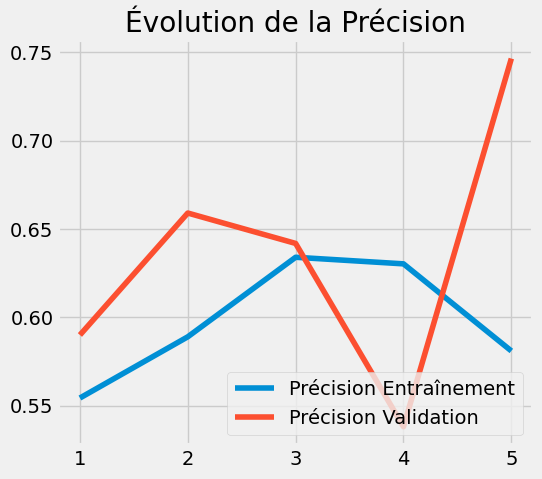

In [88]:
#  Tracer la précision
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Précision Entraînement')
plt.plot(epochs_range, val_acc, label='Précision Validation')
plt.legend(loc='lower right')
plt.title('Évolution de la Précision')

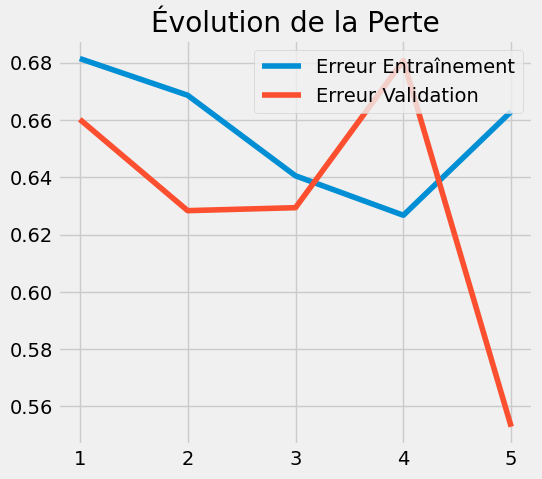

In [89]:
# Tracer la perte (erreur)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Erreur Entraînement')
plt.plot(epochs_range, val_loss, label='Erreur Validation')
plt.legend(loc='upper right')
plt.title('Évolution de la Perte')

plt.show()

amélioration du model
Ajoutons une couche Dropout(0.5) après LSTM


In [92]:
from tensorflow.keras.layers import Dropout

# Construire un modèle amélioré avec Dropout
model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=200),
    LSTM(64, return_sequences=False),
    Dropout(0.5),  # ⬅️ Dropout pour réduire le surajustement
    Dense(64, activation='relu'),  # ⬅️ Nouvelle couche dense pour mieux apprendre
    Dropout(0.5),  # ⬅️ Encore un Dropout
    Dense(1, activation='sigmoid')
])

# Compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, 200))

# Affichage du résumé
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 200, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 677,249 (2.58 MB)

 Trainable params: 677,249 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
history = model.fit(
    X_train, y_train,
    epochs=5,  # Commence avec 5 époques
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 95s 74ms/step - accuracy: 0.5033 - loss: 0.6952 - val_accuracy: 0.5244 - val_loss: 0.6876
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 91s 73ms/step - accuracy: 0.5449 - loss: 0.6828 - val_accuracy: 0.5238 - val_loss: 0.6876
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 140s 71ms/step - accuracy: 0.5315 - loss: 0.6815 - val_accuracy: 0.5997 - val_loss: 0.6331
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 149s 77ms/step - accuracy: 0.6272 - loss: 0.6253 - val_accuracy: 0.8018 - val_loss: 0.4665
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 137s 73ms/step - accuracy: 0.8120 - loss: 0.4347 - val_accuracy: 0.8623 - val_loss: 0.3308


In [94]:
# Évaluation finale du modèle sur les données de test
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

# Affichage des résultats
print(f" Précision finale sur les données de test : {test_accuracy:.4f}")
print(f" Erreur finale sur les données de test : {test_loss:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8636 - loss: 0.3288
 Précision finale sur les données de test : 0.8623
 Erreur finale sur les données de test : 0.3308
